## WeatherPy

A Python script to visualize the weather of 500+ cities across the world of varying distance from the equator.

The objective is to build a series of scatter plots to showcase the following relationships:

* Temperature (F) vs. Latitude
* Humidity (%) vs. Latitude
* Cloudiness (%) vs. Latitude
* Wind Speed (mph) vs. Latitude

The final notebook shows:

* Randomly select **at least** 500 unique (non-repeat) cities based on latitude and longitude.
* Perform a weather check on each of the cities using a series of successive API calls.
* Include a print log of each city as it's being processed with the city number, city name, and requested URL.
* a CSV of all data retrieved and png images for each scatter plot.

### Summary

•	Temperature shows decrease in magnitude north and south of the equator with highest temperature observed around       the equator.
•	Lower temperatures observed in the North side (Northern part of the globe + latitude) compare to the southern part     of the globe – e.g. North part spans from 35deg to -20deg (most northern locations) . while the south part goes       from about 35deg to 0 deg at the most southern locations
•	The clouds readings seem artificial with many locations have exactly same readings
•	Wind seems faster in the Northern part  
•	Contour maps may help understand the behavior of weather in 2D sense 



In [419]:
# Import Libr
from citipy import citipy
import random
import numpy as np
import gzip
import json
import requests # best practice to keep it as requests not as req 
import pandas as pd
import matplotlib.pyplot as plt
import time

### Extracting Cities, Coords, and ID  

City ID can be used later to extract data from Open WeatherMap API - the site recommends using ID instead of city Cords

In [291]:
# import Json Data file form api.openweathermap.org that included all location info and ID needed to req. weather data 

jsonfilename="data/city.list.json.gz" # this file can be downloaded from the OpenWeatherMap API
with gzip.GzipFile(jsonfilename, 'r') as data:        # 4. gzip
    json_bytes = data.read()                          # 3. bytes (i.e. UTF-8)
    json_str = json_bytes.decode('utf-8')             # 2. string
    city_json_data = json.loads(json_str)             # 1. data will include all weather stations - per city and lat long as a json object 

Table all city data – data frame - 

In [292]:
# use list comprehensions to produce the data 
city_id=[city_json_data[city]['id'] for city in range(len(city_json_data))]
city_name=[city_json_data[city]['name'] for city in range(len(city_json_data))]
city_country=[city_json_data[city]['country'] for city in range(len(city_json_data))]
city_cord_lat=[city_json_data[city]['coord']['lat'] for city in range(len(city_json_data))]
city_cord_lon=[city_json_data[city]['coord']['lon'] for city in range(len(city_json_data))]

In [293]:
# Make a padnas dataframe 
cityAPI_DATA = pd.DataFrame(
    {'id': city_id,
     'name': city_name,
     'country': city_country,
     'lat': city_cord_lat,
     'lng' : city_cord_lon
    })

cityAPI_DATA.to_csv('data/cityAPI_DATA.csv')

In [294]:
cityAPI_DATA.head()

,country,id,lat,lng,name
0,UA,707860,44.549999,34.283333,Hurzuf
1,RU,519188,55.683334,37.666668,Novinki
2,NP,1283378,28.000000,84.633331,Gorkhā
3,IN,1270260,29.000000,76.000000,State of Haryāna
4,UA,708546,44.599998,33.900002,Holubynka


In [368]:
# Slice Latitude - will help selection and prevent bias from dens regions like Europe 
lat_cell=1 # Lat Slice deg
lat_cell_range=lat_cell/2

lat_min=cityAPI_DATA['lat'].min() - lat_cell
lat_max=cityAPI_DATA['lat'].max() + lat_cell

lat_counter=0
lat_select={}
for i in np.arange(lat_min,lat_max,lat_cell):
    select_id=[]
    select_lng=[]
    select_id=((cityAPI_DATA[(cityAPI_DATA['lat'] > (i)) & (cityAPI_DATA['lat'] < (i+(lat_cell_range/2)))])['id'].tolist())
    select_lng=((cityAPI_DATA[(cityAPI_DATA['lat'] > (i)) & (cityAPI_DATA['lat'] < (i+(lat_cell_range/2)))])['lng'].tolist())
    lat_select[lat_counter] = (select_id, select_lng)
    lat_counter +=1
print(f'Number of Latitude slices: {len(lat_select)}')


Number of Latitude slices: 159


In [369]:
# to loop over the selected latitude slices and produce longitude slices  
lng_cell=2.0 # longitude Slice Deg 
lng_cell_range=lng_cell/2

lng_min=cityAPI_DATA['lng'].min() - lng_cell
lng_max=cityAPI_DATA['lng'].max() + lng_cell

lng_select=[]
for i in range(lat_counter):
    for a in np.arange(lng_min,lng_max,lng_cell):
        current_select=[]
        counter=0
        for lng in (lat_select[i][1]):
            if a-lng_cell_range < lng < a+lng_cell_range:
                current_select.append(lat_select[i][0][counter])
            counter=counter+1
        lng_select.append(current_select)

In [370]:
#with out Bias - select from every cell lat and long - a city coords 
RandIds=[]
count=0
for select in range(len(lng_select)):
    if len(lng_select[select])>0:

        RandIds.append(random.sample(lng_select[select], 1))
        count=count+1

ids_list=[RandIds[i][0] for i in range(len(RandIds))]
if len(set(ids_list)) < count: # this is to exclude repeated locations 
    list_set=set(ids_list)
    ids_list=[ID for ID in list_set]

print(f'{total_cities} Number of available cities (weather stations) from api.openweathermap.org')
print(f'{len(ids_list)} Selected City ID count ')
cityP=(len(ids_list))/(total_cities) *100
cityP=round(cityP)
print(f'~{cityP}% selected from available cities')

209579 Number of available cities (weather stations) from api.openweathermap.org
4035 Selected City ID count 
~2% selected from available cities


In [371]:
# to randomly reduce the city locations
select=f'Enter Number of Cities - equal or less than: {len(ids_list)} cities: '
rand=int(input(select))

Enter Number of Cities - equal or less than: 4035 cities: 3000


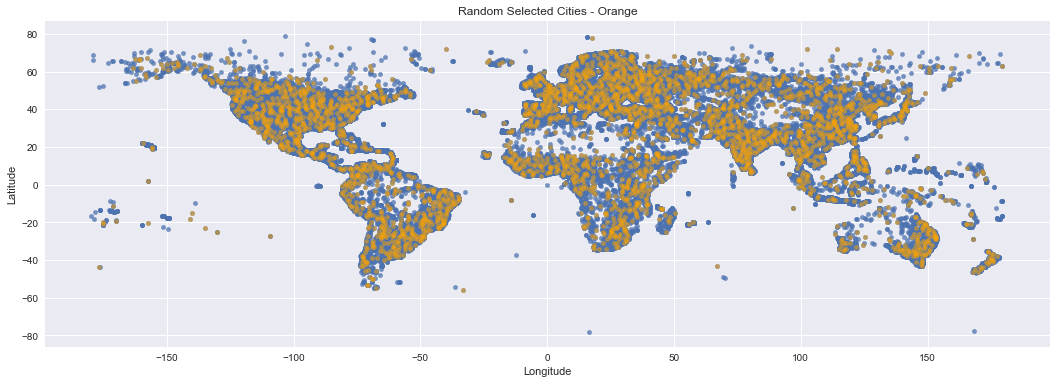

In [372]:
# to randomly reduce the city locations
random_city=random.sample(ids_list, rand)
select_ids=pd.Series(random_city).to_frame()
select_ids.columns =['id']

df_random_ids=pd.merge(select_ids, cityAPI_DATA, on='id')

ax = cityAPI_DATA.plot(x='lng', y='lat', kind='scatter', figsize=(18,6), grid=True, alpha=.75)
cit=df_random_ids.plot(x='lng', y='lat', kind='scatter', figsize=(18,6), grid=True, color="orange", alpha=.5, ax=ax)

# plot locations and check for randomness
plt.title('Random Selected Cities - Orange')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()

In [373]:
gr=round(rand/10) # how many city per query 
ids_lists = [random_city[i:i+gr] for i in range(0, len(random_city), gr)]
gr

300

In [374]:
# req data from API api.openweathermap.org

APIData=[]
city_count=1
extracted=0
group=0
for id_group in ids_lists:
    base_url = "http://api.openweathermap.org/data/2.5/forecast"
    API_Key = 'xxxxxxx' # your key goes here 
    units = 'metric'
    group+=1

    count=0
    city_count=1
    for cityID in id_group:
        #city_count=1
        parms ={
            "id": str(cityID),
            "units": units,
            "mode": "json",
            "APPID": API_Key    
        }
        resp=requests.get(base_url, params=parms).json()
        
        print('______')
        try: # some ID do not have city wich will produce an error - so try and except used to skip that ID 
            print('Extracting data for city#: ' +str(city_count)  + '  Set: ' + str(group) + ' Station ID: ' + str(resp['city']['id']) + ' City: ' + resp['city']['name'] )
            APIData.append(resp)
            city_count+=1
            count+=1
            extracted +=1
        except:
            print('one ID does not have city')
    print('Data extracted from api.openweathermap.org for ' + str(count) + ' Stations')
    print('____')
    time.sleep(120)

print('---------------------------------------')
print(f'Weather Data for : {extracted} cities')
print('---------------------------------------')

______
Extracting data for city#: 1  Set: 1 Station ID: 2303611 City: Axim
______
Extracting data for city#: 2  Set: 1 Station ID: 3855639 City: Fatraló
______
Extracting data for city#: 3  Set: 1 Station ID: 2789223 City: Peerstalle
______
Extracting data for city#: 4  Set: 1 Station ID: 1168021 City: Pindi Bhattian
______
Extracting data for city#: 5  Set: 1 Station ID: 5610054 City: Three Creek
______
Extracting data for city#: 6  Set: 1 Station ID: 2445702 City: Diffa
______
Extracting data for city#: 7  Set: 1 Station ID: 505707 City: Pozhara
______
Extracting data for city#: 8  Set: 1 Station ID: 5090246 City: Newmarket
______
Extracting data for city#: 9  Set: 1 Station ID: 423328 City: Bururi
______
Extracting data for city#: 10  Set: 1 Station ID: 463516 City: Zharkovskiy
______
Extracting data for city#: 11  Set: 1 Station ID: 4792484 City: Wattsville
______
Extracting data for city#: 12  Set: 1 Station ID: 1506272 City: Respublika Altay
______
Extracting data for city#: 13  

______
Extracting data for city#: 102  Set: 1 Station ID: 2012425 City: Zugdeli
______
Extracting data for city#: 103  Set: 1 Station ID: 407094 City: Al Jamimah
______
Extracting data for city#: 104  Set: 1 Station ID: 2383653 City: Préfecture de l’ Ouham
______
Extracting data for city#: 105  Set: 1 Station ID: 2231835 City: East Region
______
Extracting data for city#: 106  Set: 1 Station ID: 5572979 City: Tulelake
______
Extracting data for city#: 107  Set: 1 Station ID: 4981804 City: Vinalhaven
______
Extracting data for city#: 108  Set: 1 Station ID: 3933104 City: Pangoa
______
Extracting data for city#: 109  Set: 1 Station ID: 2038643 City: Anjia
______
Extracting data for city#: 110  Set: 1 Station ID: 7839599 City: Laverton
______
Extracting data for city#: 111  Set: 1 Station ID: 2696479 City: Lesjofors
______
Extracting data for city#: 112  Set: 1 Station ID: 1273463 City: Darlawn
______
Extracting data for city#: 113  Set: 1 Station ID: 1489962 City: Tavda
______
Extracting

______
Extracting data for city#: 203  Set: 1 Station ID: 1626197 City: Provinsi Sumatera Barat
______
Extracting data for city#: 204  Set: 1 Station ID: 3539662 City: San José
______
Extracting data for city#: 205  Set: 1 Station ID: 3995012 City: Estado de Nayarit
______
Extracting data for city#: 206  Set: 1 Station ID: 210379 City: Lusambo
______
Extracting data for city#: 207  Set: 1 Station ID: 3391188 City: Primavera
______
Extracting data for city#: 208  Set: 1 Station ID: 3995667 City: Mochis
______
Extracting data for city#: 209  Set: 1 Station ID: 3350372 City: Catabola
______
Extracting data for city#: 210  Set: 1 Station ID: 5010569 City: South Monroe
______
Extracting data for city#: 211  Set: 1 Station ID: 3372659 City: Santa Ana
______
Extracting data for city#: 212  Set: 1 Station ID: 898947 City: Senanga
______
Extracting data for city#: 213  Set: 1 Station ID: 1655177 City: Muang Long
______
Extracting data for city#: 214  Set: 1 Station ID: 538785 City: Kurilikha
__

______
Extracting data for city#: 1  Set: 2 Station ID: 4380170 City: Carter County
______
Extracting data for city#: 2  Set: 2 Station ID: 656083 City: Jamsa
______
Extracting data for city#: 3  Set: 2 Station ID: 1610211 City: Kao Liao
______
Extracting data for city#: 4  Set: 2 Station ID: 1702166 City: Managok
______
Extracting data for city#: 5  Set: 2 Station ID: 2384205 City: Préfecture de la Nana-Mambéré
______
Extracting data for city#: 6  Set: 2 Station ID: 484856 City: Agidel
______
Extracting data for city#: 7  Set: 2 Station ID: 376450 City: Dilling
______
Extracting data for city#: 8  Set: 2 Station ID: 1733036 City: Terengganu
______
Extracting data for city#: 9  Set: 2 Station ID: 636174 City: Sotkamo
______
Extracting data for city#: 10  Set: 2 Station ID: 372386 City: Kinana
______
Extracting data for city#: 11  Set: 2 Station ID: 2222518 City: Pongo
______
Extracting data for city#: 12  Set: 2 Station ID: 3461891 City: Guarani das Missões
______
Extracting data for c

______
Extracting data for city#: 103  Set: 2 Station ID: 1254858 City: Tasgaon
______
Extracting data for city#: 104  Set: 2 Station ID: 239880 City: Central African Republic
______
Extracting data for city#: 105  Set: 2 Station ID: 1298852 City: Rakhine State
______
Extracting data for city#: 106  Set: 2 Station ID: 5978129 City: Hudson
______
Extracting data for city#: 107  Set: 2 Station ID: 240396 City: Préfecture de la Basse-Kotto
______
Extracting data for city#: 108  Set: 2 Station ID: 155016 City: Malinyi
______
Extracting data for city#: 109  Set: 2 Station ID: 6942801 City: Grand-Sault
______
Extracting data for city#: 110  Set: 2 Station ID: 1259954 City: Peddapuram
______
Extracting data for city#: 111  Set: 2 Station ID: 2502924 City: Boukadir
______
Extracting data for city#: 112  Set: 2 Station ID: 1270994 City: Gondal
______
Extracting data for city#: 113  Set: 2 Station ID: 5871330 City: Paxson
______
Extracting data for city#: 114  Set: 2 Station ID: 3880143 City: Me

______
Extracting data for city#: 203  Set: 2 Station ID: 1511542 City: Antipayuta
______
Extracting data for city#: 204  Set: 2 Station ID: 5919263 City: Centreville
______
Extracting data for city#: 205  Set: 2 Station ID: 6613851 City: Semoy
______
Extracting data for city#: 206  Set: 2 Station ID: 7753827 City: Cibangban Girang
______
Extracting data for city#: 207  Set: 2 Station ID: 2182853 City: Sentry Hill
______
Extracting data for city#: 208  Set: 2 Station ID: 2029669 City: Ömnögovĭ Aymag
______
Extracting data for city#: 209  Set: 2 Station ID: 184433 City: Nanyuki
______
Extracting data for city#: 210  Set: 2 Station ID: 4032283 City: Kingdom of Tonga
______
Extracting data for city#: 211  Set: 2 Station ID: 5992095 City: Kimmirut
______
Extracting data for city#: 212  Set: 2 Station ID: 3356343 City: Karasburg
______
Extracting data for city#: 213  Set: 2 Station ID: 7349654 City: Hanjiaji
______
Extracting data for city#: 214  Set: 2 Station ID: 1516306 City: Bayanbulag


______
Extracting data for city#: 2  Set: 3 Station ID: 1784790 City: Zhaxi
______
Extracting data for city#: 3  Set: 3 Station ID: 4036284 City: Alofi
______
Extracting data for city#: 4  Set: 3 Station ID: 3655272 City: La Concordia
______
Extracting data for city#: 5  Set: 3 Station ID: 1683411 City: Tampilisan
______
Extracting data for city#: 6  Set: 3 Station ID: 3832640 City: Partido de Villarino
______
Extracting data for city#: 7  Set: 3 Station ID: 1524298 City: Aqsu
______
Extracting data for city#: 8  Set: 3 Station ID: 243783 City: Goz Beida
______
Extracting data for city#: 9  Set: 3 Station ID: 3822620 City: Salvador Alvarado
______
Extracting data for city#: 10  Set: 3 Station ID: 2043531 City: Kapsan-up
______
Extracting data for city#: 11  Set: 3 Station ID: 116667 City: Saveh
______
Extracting data for city#: 12  Set: 3 Station ID: 5124411 City: Lima
______
Extracting data for city#: 13  Set: 3 Station ID: 4107630 City: Danville
______
Extracting data for city#: 14  

______
Extracting data for city#: 102  Set: 3 Station ID: 1121418 City: Yahya Khel
______
Extracting data for city#: 103  Set: 3 Station ID: 2400454 City: Province du Haut-Ogooué
______
Extracting data for city#: 104  Set: 3 Station ID: 547630 City: Klimenitsy
______
Extracting data for city#: 105  Set: 3 Station ID: 1623024 City: Tumbit
______
Extracting data for city#: 106  Set: 3 Station ID: 4878229 City: Tama
______
Extracting data for city#: 107  Set: 3 Station ID: 1280659 City: Luzhang
______
Extracting data for city#: 108  Set: 3 Station ID: 345046 City: Adi Keyh
______
Extracting data for city#: 109  Set: 3 Station ID: 6945992 City: Betsiamites
______
Extracting data for city#: 110  Set: 3 Station ID: 3166022 City: Surano
______
Extracting data for city#: 111  Set: 3 Station ID: 2056029 City: Entuziastov
______
Extracting data for city#: 112  Set: 3 Station ID: 551047 City: Kerchevskiy
______
Extracting data for city#: 113  Set: 3 Station ID: 1154519 City: Tha Maka
______
Extra

______
Extracting data for city#: 202  Set: 3 Station ID: 3969433 City: Alto Alegre do Parecis
______
Extracting data for city#: 203  Set: 3 Station ID: 2121197 City: Sinegorye
______
Extracting data for city#: 204  Set: 3 Station ID: 921064 City: Central Province
______
Extracting data for city#: 205  Set: 3 Station ID: 1914622 City: Hongmao
______
Extracting data for city#: 206  Set: 3 Station ID: 7423527 City: Sonikot
______
Extracting data for city#: 207  Set: 3 Station ID: 4556595 City: Biglerville
______
Extracting data for city#: 208  Set: 3 Station ID: 1850872 City: Takefu
______
Extracting data for city#: 209  Set: 3 Station ID: 986958 City: Krompan
______
Extracting data for city#: 210  Set: 3 Station ID: 2973847 City: Spycker
______
Extracting data for city#: 211  Set: 3 Station ID: 2773680 City: Kostendorf
______
Extracting data for city#: 212  Set: 3 Station ID: 539970 City: Kuchino
______
Extracting data for city#: 213  Set: 3 Station ID: 7838650 City: Djebilet Rosfa
____

______
Extracting data for city#: 1  Set: 4 Station ID: 3465459 City: Coronel Vivida
______
Extracting data for city#: 2  Set: 4 Station ID: 2340788 City: Gidan Sarkin Gardi
______
Extracting data for city#: 3  Set: 4 Station ID: 3838563 City: Departamento de Rosario de la Frontera
______
Extracting data for city#: 4  Set: 4 Station ID: 1851141 City: Takaharu
______
Extracting data for city#: 5  Set: 4 Station ID: 3464547 City: Dom Pedrito
______
Extracting data for city#: 6  Set: 4 Station ID: 4260453 City: Linton
______
Extracting data for city#: 7  Set: 4 Station ID: 495891 City: Shamkhal-Termen
______
Extracting data for city#: 8  Set: 4 Station ID: 6073742 City: Mill Bay
______
Extracting data for city#: 9  Set: 4 Station ID: 3874579 City: Purranque
______
Extracting data for city#: 10  Set: 4 Station ID: 4501057 City: Cape May Court House
______
Extracting data for city#: 11  Set: 4 Station ID: 2649784 City: Eyemouth
______
Extracting data for city#: 12  Set: 4 Station ID: 207601

______
Extracting data for city#: 100  Set: 4 Station ID: 7839384 City: Paroo
______
Extracting data for city#: 101  Set: 4 Station ID: 5689618 City: Hettinger
______
Extracting data for city#: 102  Set: 4 Station ID: 149703 City: Sumbawanga
______
Extracting data for city#: 103  Set: 4 Station ID: 2292179 City: Bangolo
______
Extracting data for city#: 104  Set: 4 Station ID: 3471168 City: Estado da Bahia
______
Extracting data for city#: 105  Set: 4 Station ID: 2453514 City: Menaka
______
Extracting data for city#: 106  Set: 4 Station ID: 711416 City: Brody
______
Extracting data for city#: 107  Set: 4 Station ID: 1498547 City: Mokhovoye
______
Extracting data for city#: 108  Set: 4 Station ID: 147551 City: Masally Rayon
______
Extracting data for city#: 109  Set: 4 Station ID: 2358700 City: Province du Kouritenga
______
Extracting data for city#: 110  Set: 4 Station ID: 2687636 City: Nynashamn
______
Extracting data for city#: 111  Set: 4 Station ID: 4397988 City: Melzo
______
Extra

______
Extracting data for city#: 200  Set: 4 Station ID: 1276783 City: Basavakalyan
______
Extracting data for city#: 201  Set: 4 Station ID: 1519809 City: Sadchikovka
______
Extracting data for city#: 202  Set: 4 Station ID: 3483197 City: San Fernando
______
Extracting data for city#: 203  Set: 4 Station ID: 7910059 City: Ruapehu District
______
Extracting data for city#: 204  Set: 4 Station ID: 1258291 City: Rayachoti
______
Extracting data for city#: 205  Set: 4 Station ID: 7303651 City: Gasa
______
Extracting data for city#: 206  Set: 4 Station ID: 4297576 City: Lawrence County
______
Extracting data for city#: 207  Set: 4 Station ID: 2016701 City: Shimanovsk
______
Extracting data for city#: 208  Set: 4 Station ID: 2593118 City: Région de la Cuvette-Ouest
______
Extracting data for city#: 209  Set: 4 Station ID: 2335798 City: Kachia
______
Extracting data for city#: 210  Set: 4 Station ID: 2998081 City: Livarot
______
Extracting data for city#: 211  Set: 4 Station ID: 1504985 Cit

______
Extracting data for city#: 300  Set: 4 Station ID: 6357758 City: Padul
Data extracted from api.openweathermap.org for 300 Stations
____
______
Extracting data for city#: 1  Set: 5 Station ID: 2064562 City: Nornalup
______
Extracting data for city#: 2  Set: 5 Station ID: 3456739 City: Morrinhos
______
Extracting data for city#: 3  Set: 5 Station ID: 2445488 City: Dosso
______
Extracting data for city#: 4  Set: 5 Station ID: 2713974 City: Forserum
______
Extracting data for city#: 5  Set: 5 Station ID: 3822723 City: Alfredo V. Bonfil
______
Extracting data for city#: 6  Set: 5 Station ID: 2090468 City: Morobe Province
______
Extracting data for city#: 7  Set: 5 Station ID: 574614 City: Bol’shaya Sova
______
Extracting data for city#: 8  Set: 5 Station ID: 343292 City: Asosa
______
Extracting data for city#: 9  Set: 5 Station ID: 745344 City: Ilgaz
______
Extracting data for city#: 10  Set: 5 Station ID: 6691318 City: Bas-Saint-Laurent
______
Extracting data for city#: 11  Set: 5 S

______
Extracting data for city#: 101  Set: 5 Station ID: 6094265 City: O'Regan's
______
Extracting data for city#: 102  Set: 5 Station ID: 3931656 City: Pucara
______
Extracting data for city#: 103  Set: 5 Station ID: 2513637 City: Montellano
______
Extracting data for city#: 104  Set: 5 Station ID: 3853782 City: Ingeniero Luis A. Huergo
______
Extracting data for city#: 105  Set: 5 Station ID: 2658749 City: Schattdorf
______
Extracting data for city#: 106  Set: 5 Station ID: 6554432 City: Gindorf
______
Extracting data for city#: 107  Set: 5 Station ID: 4560152 City: Oliver
______
Extracting data for city#: 108  Set: 5 Station ID: 409950 City: Raḑwān
______
Extracting data for city#: 109  Set: 5 Station ID: 379102 City: Al Mijlad
______
Extracting data for city#: 110  Set: 5 Station ID: 1169663 City: Musa Khel Bazar
______
Extracting data for city#: 111  Set: 5 Station ID: 1624987 City: Tanjungagung
______
Extracting data for city#: 112  Set: 5 Station ID: 2621896 City: Frejlev
_____

______
Extracting data for city#: 200  Set: 5 Station ID: 1076194 City: Andilamena
______
Extracting data for city#: 201  Set: 5 Station ID: 312899 City: Hadim
______
Extracting data for city#: 202  Set: 5 Station ID: 2161187 City: Kogan
______
Extracting data for city#: 203  Set: 5 Station ID: 2127282 City: Aleksandrovsk-Sakhalinskiy
______
Extracting data for city#: 204  Set: 5 Station ID: 5928473 City: Côte-Nord
______
Extracting data for city#: 205  Set: 5 Station ID: 107312 City: Abqaiq
______
Extracting data for city#: 206  Set: 5 Station ID: 3421719 City: Narsaq
______
Extracting data for city#: 207  Set: 5 Station ID: 2658049 City: Wartau
______
Extracting data for city#: 208  Set: 5 Station ID: 6047817 City: Ladysmith
______
Extracting data for city#: 209  Set: 5 Station ID: 522410 City: Nevel
______
Extracting data for city#: 210  Set: 5 Station ID: 2186224 City: New Zealand
______
Extracting data for city#: 211  Set: 5 Station ID: 1166164 City: Sanghar
______
Extracting data

______
Extracting data for city#: 299  Set: 5 Station ID: 3910343 City: Mineros
______
Extracting data for city#: 300  Set: 5 Station ID: 2348892 City: Auchi
Data extracted from api.openweathermap.org for 300 Stations
____
______
Extracting data for city#: 1  Set: 6 Station ID: 1264525 City: Madugula
______
Extracting data for city#: 2  Set: 6 Station ID: 159242 City: Ikwiriri
______
Extracting data for city#: 3  Set: 6 Station ID: 3472969 City: Aguai
______
Extracting data for city#: 4  Set: 6 Station ID: 1213642 City: Provinsi Sumatera Utara
______
Extracting data for city#: 5  Set: 6 Station ID: 4402099 City: Osceola
______
Extracting data for city#: 6  Set: 6 Station ID: 1269784 City: Ilkal
______
Extracting data for city#: 7  Set: 6 Station ID: 2225991 City: Mora
______
Extracting data for city#: 8  Set: 6 Station ID: 6539815 City: Baiano
______
Extracting data for city#: 9  Set: 6 Station ID: 917524 City: Copperbelt Province
______
Extracting data for city#: 10  Set: 6 Station ID

______
Extracting data for city#: 100  Set: 6 Station ID: 6533368 City: Moranbah
______
Extracting data for city#: 101  Set: 6 Station ID: 1516186 City: Bulgan
______
Extracting data for city#: 102  Set: 6 Station ID: 1281556 City: Chalengkou
______
Extracting data for city#: 103  Set: 6 Station ID: 4402011 City: Oregon
______
Extracting data for city#: 104  Set: 6 Station ID: 7522396 City: Tudulinna vald
______
Extracting data for city#: 105  Set: 6 Station ID: 7626378 City: Meldal
______
Extracting data for city#: 106  Set: 6 Station ID: 2230028 City: Kontcha
______
Extracting data for city#: 107  Set: 6 Station ID: 3530267 City: Copainala
______
Extracting data for city#: 108  Set: 6 Station ID: 2037927 City: Dalain Hob
______
Extracting data for city#: 109  Set: 6 Station ID: 3854153 City: Hoyo de Epuyen
______
Extracting data for city#: 110  Set: 6 Station ID: 1216115 City: Shorchi
______
Extracting data for city#: 111  Set: 6 Station ID: 3387727 City: Serrita
______
Extracting da

______
Extracting data for city#: 199  Set: 6 Station ID: 1639304 City: Kualakapuas
______
Extracting data for city#: 200  Set: 6 Station ID: 1734576 City: Simpang Empat
______
Extracting data for city#: 201  Set: 6 Station ID: 321940 City: Baskale
______
Extracting data for city#: 202  Set: 6 Station ID: 1851883 City: Shiraoka
______
Extracting data for city#: 203  Set: 6 Station ID: 2189958 City: Hilderthorpe
______
Extracting data for city#: 204  Set: 6 Station ID: 1789593 City: Xidu
______
Extracting data for city#: 205  Set: 6 Station ID: 3441011 City: Pocitos
______
Extracting data for city#: 206  Set: 6 Station ID: 933562 City: Kweneng District
______
Extracting data for city#: 207  Set: 6 Station ID: 2844260 City: Roth
______
Extracting data for city#: 208  Set: 6 Station ID: 779622 City: Havoysund
______
Extracting data for city#: 209  Set: 6 Station ID: 8070735 City: Ipeko
______
Extracting data for city#: 210  Set: 6 Station ID: 3628488 City: San Carlos de Rio Negro
______
E

______
Extracting data for city#: 297  Set: 6 Station ID: 3129959 City: Antes
______
Extracting data for city#: 298  Set: 6 Station ID: 1114929 City: Bukhara Province
______
Extracting data for city#: 299  Set: 6 Station ID: 3457126 City: Mira Estrela
______
Extracting data for city#: 300  Set: 6 Station ID: 3587587 City: Zacapa
Data extracted from api.openweathermap.org for 300 Stations
____
______
Extracting data for city#: 1  Set: 7 Station ID: 4030656 City: Polynésie Française
______
Extracting data for city#: 2  Set: 7 Station ID: 3844159 City: Miramar
______
Extracting data for city#: 3  Set: 7 Station ID: 472039 City: Voronezhskaya Oblast’
______
Extracting data for city#: 4  Set: 7 Station ID: 808832 City: Otdokhnina
______
Extracting data for city#: 5  Set: 7 Station ID: 380129 City: Ad Diwem
______
Extracting data for city#: 6  Set: 7 Station ID: 2142877 City: Wowan
______
Extracting data for city#: 7  Set: 7 Station ID: 2667757 City: Torup
______
Extracting data for city#: 8

______
Extracting data for city#: 96  Set: 7 Station ID: 697637 City: Pereyaslav-Khmelnytskyy
______
Extracting data for city#: 97  Set: 7 Station ID: 5887973 City: Atikameg
______
Extracting data for city#: 98  Set: 7 Station ID: 5952703 City: Fillmore
______
Extracting data for city#: 99  Set: 7 Station ID: 2350172 City: Amassoma
______
Extracting data for city#: 100  Set: 7 Station ID: 6137271 City: Saguenay/Lac-Saint-Jean
______
Extracting data for city#: 101  Set: 7 Station ID: 505665 City: Pozhva
______
Extracting data for city#: 102  Set: 7 Station ID: 146137 City: Polis
______
Extracting data for city#: 103  Set: 7 Station ID: 215668 City: Kabalo
______
Extracting data for city#: 104  Set: 7 Station ID: 1732602 City: Jerantut
______
Extracting data for city#: 105  Set: 7 Station ID: 2033595 City: Xiwanzi
______
Extracting data for city#: 106  Set: 7 Station ID: 2966075 City: Bohola
______
Extracting data for city#: 107  Set: 7 Station ID: 3687975 City: Calamar
______
Extracting

______
Extracting data for city#: 195  Set: 7 Station ID: 4854644 City: Dunlap
______
Extracting data for city#: 196  Set: 7 Station ID: 1476203 City: Ster Giyan
______
Extracting data for city#: 197  Set: 7 Station ID: 732162 City: Dolen Bliznak
______
Extracting data for city#: 198  Set: 7 Station ID: 1855134 City: Nishiwaki
______
Extracting data for city#: 199  Set: 7 Station ID: 1497749 City: Nikita
______
Extracting data for city#: 200  Set: 7 Station ID: 3399336 City: Francisco Santos
______
Extracting data for city#: 201  Set: 7 Station ID: 1492782 City: Semënovka
______
Extracting data for city#: 202  Set: 7 Station ID: 2888047 City: Klein Wanzleben
______
Extracting data for city#: 203  Set: 7 Station ID: 1090415 City: Chirongui
______
Extracting data for city#: 204  Set: 7 Station ID: 1720594 City: Calantac
______
Extracting data for city#: 205  Set: 7 Station ID: 3837152 City: Provincia de San Juan
______
Extracting data for city#: 206  Set: 7 Station ID: 3645806 City: Chic

______
Extracting data for city#: 294  Set: 7 Station ID: 3433956 City: Federal
______
Extracting data for city#: 295  Set: 7 Station ID: 6173456 City: Vanscoy
______
Extracting data for city#: 296  Set: 7 Station ID: 6182516 City: Willowvale
______
Extracting data for city#: 297  Set: 7 Station ID: 110831 City: Shah Pasand
______
Extracting data for city#: 298  Set: 7 Station ID: 2035607 City: Inner Mongolia Autonomous Region
______
Extracting data for city#: 299  Set: 7 Station ID: 934900 City: Nsoko
______
Extracting data for city#: 300  Set: 7 Station ID: 7626383 City: Stugudalen
Data extracted from api.openweathermap.org for 300 Stations
____
______
Extracting data for city#: 1  Set: 8 Station ID: 5134736 City: Sackets Harbor
______
Extracting data for city#: 2  Set: 8 Station ID: 5939449 City: Dingwall
______
Extracting data for city#: 3  Set: 8 Station ID: 5864720 City: Indian
______
Extracting data for city#: 4  Set: 8 Station ID: 2378903 City: Wilaya de l'Inchiri
______
Extrac

______
Extracting data for city#: 94  Set: 8 Station ID: 3397355 City: Jipuba
______
Extracting data for city#: 95  Set: 8 Station ID: 2063177 City: Point Pass
______
Extracting data for city#: 96  Set: 8 Station ID: 601417 City: Oltinkol
______
Extracting data for city#: 97  Set: 8 Station ID: 1321850 City: Ayeyarwady Division
______
Extracting data for city#: 98  Set: 8 Station ID: 5842753 City: Wheatland
______
Extracting data for city#: 99  Set: 8 Station ID: 142000 City: Bahar
______
Extracting data for city#: 100  Set: 8 Station ID: 6074440 City: Minaki
______
Extracting data for city#: 101  Set: 8 Station ID: 5688604 City: Crosby
______
Extracting data for city#: 102  Set: 8 Station ID: 3488020 City: Williamsfield
______
Extracting data for city#: 103  Set: 8 Station ID: 830603 City: Lappland
______
Extracting data for city#: 104  Set: 8 Station ID: 2206890 City: Masterton
______
Extracting data for city#: 105  Set: 8 Station ID: 3515056 City: Tulcingo del Valle
______
Extractin

______
Extracting data for city#: 194  Set: 8 Station ID: 3686110 City: Republic of Colombia
______
Extracting data for city#: 195  Set: 8 Station ID: 1488190 City: Ust-Kan
______
Extracting data for city#: 196  Set: 8 Station ID: 7839698 City: Bombala
______
Extracting data for city#: 197  Set: 8 Station ID: 8052580 City: Dabagou
______
Extracting data for city#: 198  Set: 8 Station ID: 5590383 City: Custer County
______
Extracting data for city#: 199  Set: 8 Station ID: 5688789 City: Dickinson
______
Extracting data for city#: 200  Set: 8 Station ID: 1504081 City: Kaz
______
Extracting data for city#: 201  Set: 8 Station ID: 1516036 City: Dzag
______
Extracting data for city#: 202  Set: 8 Station ID: 338345 City: Edd
______
Extracting data for city#: 203  Set: 8 Station ID: 3946937 City: Azangaro
______
Extracting data for city#: 204  Set: 8 Station ID: 3371201 City: Karas
______
Extracting data for city#: 205  Set: 8 Station ID: 1113217 City: Zabol
______
Extracting data for city#: 

______
Extracting data for city#: 295  Set: 8 Station ID: 5373463 City: Minneola
______
Extracting data for city#: 296  Set: 8 Station ID: 650224 City: Kuopio
______
Extracting data for city#: 297  Set: 8 Station ID: 1805743 City: Jincheng
______
Extracting data for city#: 298  Set: 8 Station ID: 2649372 City: Fishguard
______
Extracting data for city#: 299  Set: 8 Station ID: 2175959 City: Biboohra
______
Extracting data for city#: 300  Set: 8 Station ID: 1337248 City: Sherpur
Data extracted from api.openweathermap.org for 300 Stations
____
______
Extracting data for city#: 1  Set: 9 Station ID: 997324 City: Hattingspruit
______
Extracting data for city#: 2  Set: 9 Station ID: 496461 City: Setolovo
______
Extracting data for city#: 3  Set: 9 Station ID: 3120445 City: Igea
______
Extracting data for city#: 4  Set: 9 Station ID: 2189343 City: Kaeo
______
Extracting data for city#: 5  Set: 9 Station ID: 306571 City: Konya
______
Extracting data for city#: 6  Set: 9 Station ID: 3461051 Ci

______
Extracting data for city#: 95  Set: 9 Station ID: 2017370 City: Russian Federation
______
Extracting data for city#: 96  Set: 9 Station ID: 3192224 City: Pula
______
Extracting data for city#: 97  Set: 9 Station ID: 1262963 City: State of Mizoram
______
Extracting data for city#: 98  Set: 9 Station ID: 5914132 City: Campbell River
______
Extracting data for city#: 99  Set: 9 Station ID: 3472758 City: Alambique
______
Extracting data for city#: 100  Set: 9 Station ID: 3439705 City: Oriental Republic of Uruguay
______
Extracting data for city#: 101  Set: 9 Station ID: 2505346 City: Beïda Bordj
______
Extracting data for city#: 102  Set: 9 Station ID: 476297 City: Vazhiny
______
Extracting data for city#: 103  Set: 9 Station ID: 5446453 City: Sharon Springs
______
Extracting data for city#: 104  Set: 9 Station ID: 5858176 City: Buckland
______
Extracting data for city#: 105  Set: 9 Station ID: 2656500 City: Ballykelly
______
Extracting data for city#: 106  Set: 9 Station ID: 783950

______
Extracting data for city#: 193  Set: 9 Station ID: 6114471 City: Puvirnituq
______
Extracting data for city#: 194  Set: 9 Station ID: 1261750 City: Narsingi
______
Extracting data for city#: 195  Set: 9 Station ID: 5058560 City: Casselton
______
Extracting data for city#: 196  Set: 9 Station ID: 260897 City: Karpásion
______
Extracting data for city#: 197  Set: 9 Station ID: 1258297 City: Rawatbhata
______
Extracting data for city#: 198  Set: 9 Station ID: 5703766 City: Eureka County
______
Extracting data for city#: 199  Set: 9 Station ID: 1040039 City: Matararique
______
Extracting data for city#: 200  Set: 9 Station ID: 922741 City: Likasi
______
Extracting data for city#: 201  Set: 9 Station ID: 457714 City: Madona
______
Extracting data for city#: 202  Set: 9 Station ID: 2023298 City: Kalanguy
______
Extracting data for city#: 203  Set: 9 Station ID: 2036443 City: Jinshan
______
Extracting data for city#: 204  Set: 9 Station ID: 580243 City: Avneporog
______
Extracting data

______
Extracting data for city#: 292  Set: 9 Station ID: 2387495 City: Carnot
______
Extracting data for city#: 293  Set: 9 Station ID: 2444219 City: Goure
______
Extracting data for city#: 294  Set: 9 Station ID: 1091088 City: Barakani
______
Extracting data for city#: 295  Set: 9 Station ID: 1807413 City: Huangjindong
______
Extracting data for city#: 296  Set: 9 Station ID: 2430873 City: Région du Kanem
______
Extracting data for city#: 297  Set: 9 Station ID: 6355527 City: Alhabia
______
Extracting data for city#: 298  Set: 9 Station ID: 264748 City: Apollonia
______
Extracting data for city#: 299  Set: 9 Station ID: 1877872 City: Chunghwa
______
Extracting data for city#: 300  Set: 9 Station ID: 5835178 City: Pinedale
Data extracted from api.openweathermap.org for 300 Stations
____
______
Extracting data for city#: 1  Set: 10 Station ID: 2149133 City: Somerton
______
Extracting data for city#: 2  Set: 10 Station ID: 539221 City: Kumylzhenskaya
______
Extracting data for city#: 3 

______
Extracting data for city#: 92  Set: 10 Station ID: 7869868 City: ChangQiao
______
Extracting data for city#: 93  Set: 10 Station ID: 5041752 City: Pipestone
______
Extracting data for city#: 94  Set: 10 Station ID: 505112 City: Privodino
______
Extracting data for city#: 95  Set: 10 Station ID: 930283 City: Thyolo District
______
Extracting data for city#: 96  Set: 10 Station ID: 488881 City: Starobaltachevo
______
Extracting data for city#: 97  Set: 10 Station ID: 4865974 City: Malvern
______
Extracting data for city#: 98  Set: 10 Station ID: 3598131 City: Ciudad Melchor de Mencos
______
Extracting data for city#: 99  Set: 10 Station ID: 703317 City: Lazurne
______
Extracting data for city#: 100  Set: 10 Station ID: 3435107 City: Curuzú
______
Extracting data for city#: 101  Set: 10 Station ID: 1256050 City: Sirsaganj
______
Extracting data for city#: 102  Set: 10 Station ID: 6643965 City: Nixi
______
Extracting data for city#: 103  Set: 10 Station ID: 6231568 City: Takanini
__

______
Extracting data for city#: 190  Set: 10 Station ID: 2341656 City: Gashua
______
Extracting data for city#: 191  Set: 10 Station ID: 1887177 City: Jinhai
______
Extracting data for city#: 192  Set: 10 Station ID: 3462388 City: Goiabeira
______
Extracting data for city#: 193  Set: 10 Station ID: 409417 City: Ali Bajramly
______
Extracting data for city#: 194  Set: 10 Station ID: 4032804 City: Waitangi
______
Extracting data for city#: 195  Set: 10 Station ID: 7071012 City: Jingang
______
Extracting data for city#: 196  Set: 10 Station ID: 7910051 City: Manawatu District
______
Extracting data for city#: 197  Set: 10 Station ID: 1267336 City: Kekri
______
Extracting data for city#: 198  Set: 10 Station ID: 3832098 City: Zavalla
______
Extracting data for city#: 199  Set: 10 Station ID: 8080514 City: Parengan
______
Extracting data for city#: 200  Set: 10 Station ID: 3533079 City: Aldama
______
Extracting data for city#: 201  Set: 10 Station ID: 1262089 City: Nakur
______
Extracting

______
Extracting data for city#: 289  Set: 10 Station ID: 5227753 City: Faulkton
______
Extracting data for city#: 290  Set: 10 Station ID: 3388145 City: Sao Raimundo Nonato
______
Extracting data for city#: 291  Set: 10 Station ID: 7072317 City: Zhuao
______
Extracting data for city#: 292  Set: 10 Station ID: 3983210 City: Sayulita
______
Extracting data for city#: 293  Set: 10 Station ID: 3854089 City: Huanqueros
______
Extracting data for city#: 294  Set: 10 Station ID: 3836992 City: San Martin
______
Extracting data for city#: 295  Set: 10 Station ID: 2877942 City: Liebenwalde
______
Extracting data for city#: 296  Set: 10 Station ID: 6174844 City: Wabush
______
Extracting data for city#: 297  Set: 10 Station ID: 3695238 City: Departamento de Loreto
______
Extracting data for city#: 298  Set: 10 Station ID: 2191332 City: Endeavour Inlet
______
Extracting data for city#: 299  Set: 10 Station ID: 1168680 City: Pabbi
______
Extracting data for city#: 300  Set: 10 Station ID: 2067260 

In [375]:
#APIcity_name=[APIData[city]['city']['name'] for city in range(len(APIData))]
APIcity_id=[APIData[city]['city']['id'] for city in range(len(APIData))]
API_date=[APIData[city]      ['list'][0]['dt_txt'] for city in range(len(APIData))]


# func for less typing 
def org_data(par1,par2):
    return ([APIData[city]['list'][0][par1][par2] for city in range(len(APIData))])

API_clouds=org_data('clouds','all')
API_humidity=org_data('main','humidity')
API_pressure=org_data('main','pressure')
API_temp_max=org_data('main','temp_max')
API_temp_min=org_data('main','temp_min')
API_temp_now=org_data('main','temp')
API_wind_deg=org_data('wind','deg')
API_wind_spped=org_data('wind','speed')

In [376]:
# take extracted data to dataframe 

API_DATA = pd.DataFrame(
    {'id': APIcity_id,
     'clouds': API_clouds,
     'date': API_date,
     'humidity': API_humidity,
     'pressure': API_pressure,
     'temp_max': API_temp_max,
     'temp_min': API_temp_min,
     'temp':API_temp_now,
     'wind_deg': API_wind_deg,
     'wind_speed': API_wind_spped
    })

In [377]:
API_DATA.head()

,clouds,date,humidity,id,pressure,temp,temp_max,temp_min,wind_deg,wind_speed
0,36,2017-11-19 03:00:00,100,2303611,1020.42,26.12,26.12,26.12,230.501,4.37
1,8,2017-11-19 03:00:00,34,3855639,999.91,16.67,16.67,16.67,316.001,5.92
2,24,2017-11-19 03:00:00,89,2789223,1030.07,5.94,6.15,5.94,311.001,5.97
3,0,2017-11-19 03:00:00,85,1168021,1010.29,11.67,11.67,11.67,268.501,1.32
4,32,2017-11-19 03:00:00,79,5610054,824.50,-8.05,-8.05,-8.06,162.501,1.67


In [378]:
API_DATA_W=pd.merge(cityAPI_DATA ,API_DATA, on='id')
API_DATA_W.head()

,country,id,lat,lng,name,clouds,date,humidity,pressure,temp,temp_max,temp_min,wind_deg,wind_speed
0,RU,2017370,60.000000,100.000000,Russian Federation,80,2017-11-19 03:00:00,84,991.81,-16.43,-16.43,-16.43,144.001,2.42
1,IN,1257986,34.049999,77.416664,Rumbak,36,2017-11-19 03:00:00,71,605.31,-18.98,-18.98,-18.98,176.501,0.37
2,AR,3858204,-24.100000,-62.476620,El Destierro,12,2017-11-19 03:00:00,34,1005.99,19.90,19.90,19.90,120.001,4.32
3,CM,2224928,2.916670,13.500000,Néméyong II,92,2017-11-19 03:00:00,99,953.87,19.82,19.82,19.82,242.001,1.12
4,FR,3017680,44.913849,6.623900,Forville,0,2017-11-19 03:00:00,52,796.29,-18.10,-18.10,-18.11,317.001,0.72


In [415]:
#output data 
API_DATA_W.to_csv('data/city_data_mrg.csv')

## City Latitude Vs Temperature -Cdeg

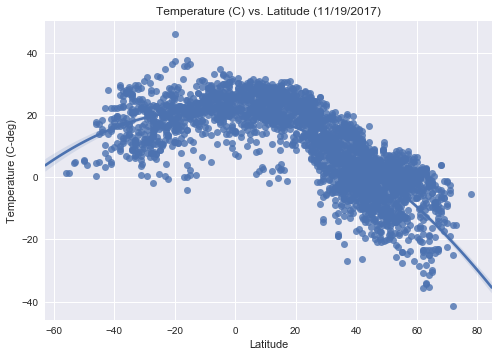

In [403]:
dat='(11/19/2017)'
import seaborn as sns
sns.regplot('lat', 'temp', data=API_DATA_W, fit_reg=True, order=2.5, marker = 'o')
#plt.ylim(-10,100)
plt.title(f'Temperature (C) vs. Latitude {dat}')
plt.xlabel('Latitude')
plt.ylabel('Temperature (C-deg)')
plt.savefig('CityLatitudeVsMaxTemperature')
plt.show()

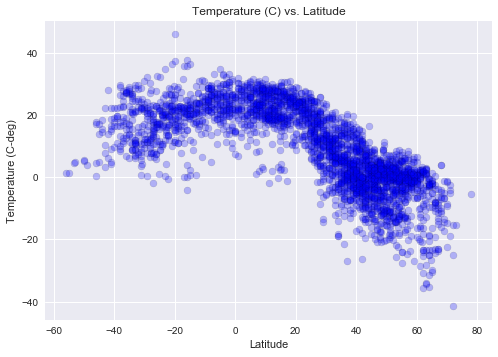

In [382]:
plt.scatter(API_DATA_W['lat'], API_DATA_W['temp'], marker = 'o', color = 'b', alpha = 0.250, edgecolors="black")

plt.title(f'City Latitude vs Max Temperature {dat}')
plt.xlabel('Latitude')
plt.ylabel('Temperature (C-deg)')
plt.title('Temperature (C) vs. Latitude')
plt.style.use('seaborn-darkgrid')
#plt.xlim(-100, 100)

#plt.savefig('CityLatitudeVsMaxTemperature')
plt.show()

## Latitude Vs Humidity%

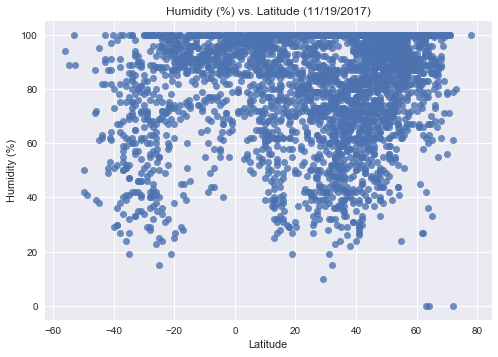

In [404]:
sns.regplot('lat', 'humidity', data=API_DATA_W, fit_reg=False)
plt.title(f'Humidity (%) vs. Latitude {dat}')
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
plt.savefig('CityLatitudeVsHumidity')
plt.show()

## Latitude Vs Clouds

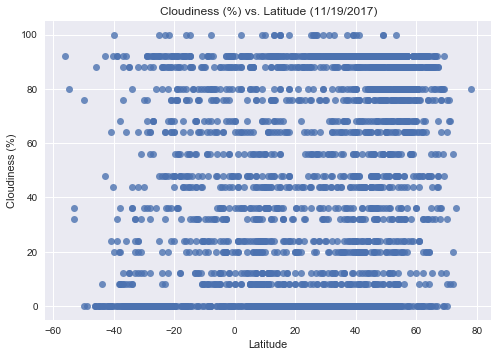

In [405]:
sns.regplot('lat', 'clouds', data=API_DATA_W, fit_reg=False)
plt.title(f'Cloudiness (%) vs. Latitude {dat}')
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.savefig('CityLatitudeVsClouds')
plt.show()

## Latitude Vs WindSpeed km-ph
 

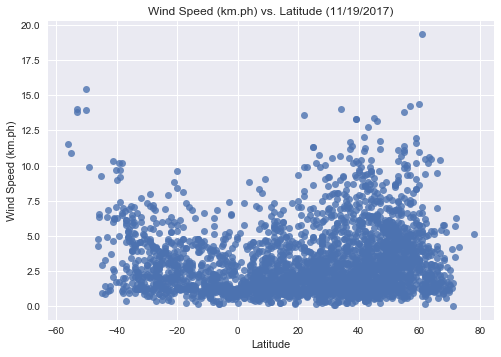

In [406]:
sns.regplot('lat', 'wind_speed', data=API_DATA_W, fit_reg=False)
plt.title(f'Wind Speed (km.ph) vs. Latitude {dat}')
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (km.ph)')
plt.savefig('CityLatitudeVsWindSpeed')
plt.show()

## Latitude Vs Wind Direction deg

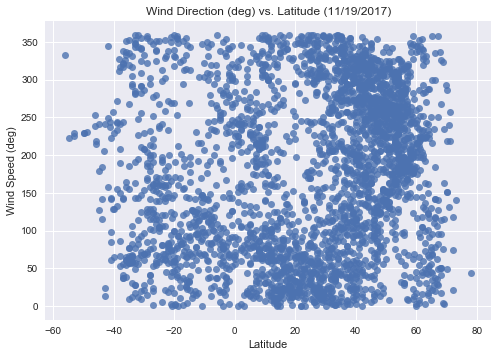

In [416]:
sns.regplot('lat', 'wind_deg', data=API_DATA_W, fit_reg=False)
plt.title(f'Wind Direction (deg) vs. Latitude {dat}')
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (deg)')
plt.savefig('CityLatitudeVsWindDir')
plt.show()

## Latitude Vs pressure 

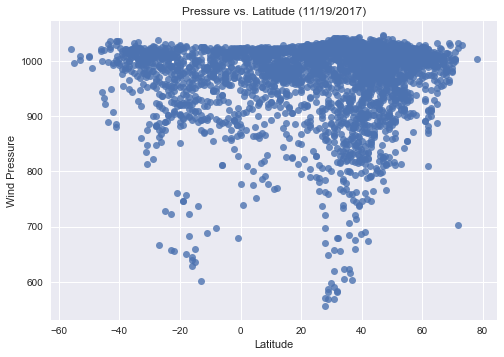

In [417]:
sns.regplot('lat', 'pressure', data=API_DATA_W, fit_reg=False)
plt.title(f'Pressure vs. Latitude {dat}')
plt.xlabel('Latitude')
plt.ylabel('Wind Pressure')
plt.savefig('CityLatitudeVspressure')
plt.show()

## Contour Map Max Temperature(Cdeg) 

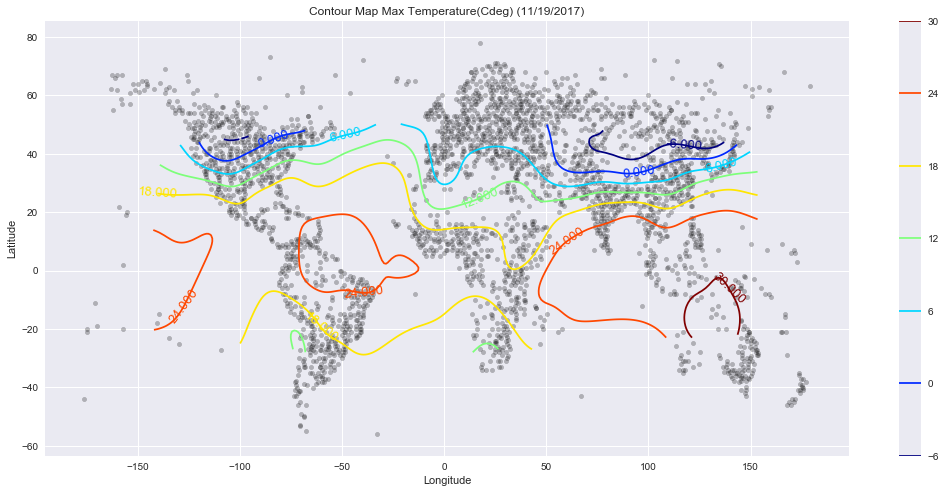

In [411]:
from scipy.interpolate import griddata
df=API_DATA_W
Y=df.lat.values
X=df.lng.values
Z=df.temp_min.values

#Create a target grid for the new interpolated z values
xi = np.arange(X.min(), X.max(), 1)
yi = np.arange(Y.min(), Y.max(), 1)
xi,yi = np.meshgrid(xi, yi)

#Interpolate zi based on X,Y,Z values land them in the xi,yi grid
zi = griddata((X, Y) ,Z ,(xi, yi), method='linear')

#Plot new contour with overlay of original scatter plot

import scipy.ndimage as ndimage
zi2 = ndimage.gaussian_filter(zi, sigma=6, order=0)
fig, ax = plt.subplots(1,1, figsize=(18,8))
contours=plt.contour(xi, yi, zi2, alpha=1, cmap=plt.cm.jet)
plt.clabel(contours, inline=False, fontsize=13)
plt.colorbar()
ax = plt.gca()
df.plot('lng', 'lat', kind='scatter', ax=ax, color='black', alpha=0.25)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title(f'Contour Map Max Temperature(Cdeg) {dat}')
plt.savefig('contour_Temp')
plt.show();

## Contour Map Wind Direction(deg)

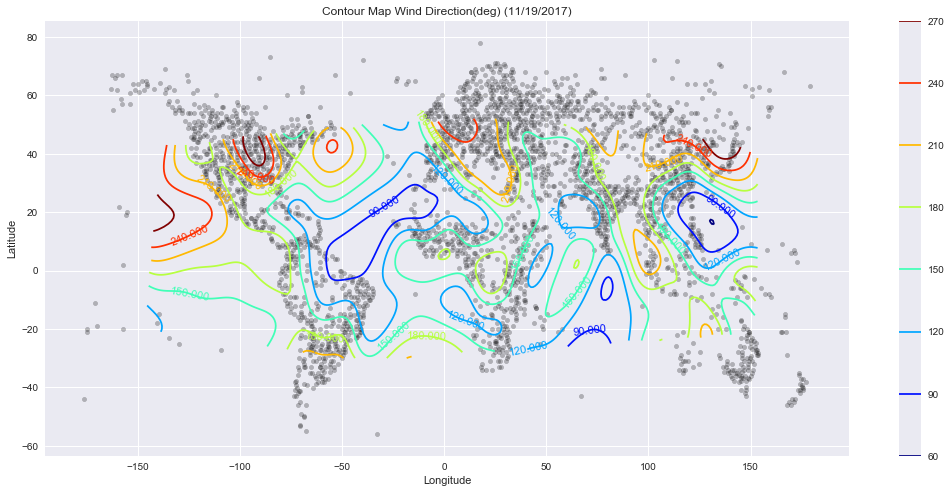

In [412]:
Z=df.wind_deg.values
#Interpolate zi based on X,Y,Z values land them in the xi,yi grid
zi = griddata((X, Y) ,Z ,(xi, yi), method='linear')

#Plot new contour with overlay of original scatter plot


zi2 = ndimage.gaussian_filter(zi, sigma=6, order=0)
fig, ax = plt.subplots(1,1, figsize=(18,8))
contours=plt.contour(xi, yi, zi2, alpha=1, cmap=plt.cm.jet)
plt.clabel(contours, inline=False, fontsize=11)
plt.colorbar()
ax = plt.gca()
df.plot('lng', 'lat', kind='scatter', ax=ax, color='black', alpha=0.25)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title(f'Contour Map Wind Direction(deg) {dat}')
plt.savefig('contour_WindDir')
plt.show();

## Contour Map Wind Speed(Km/hr) 

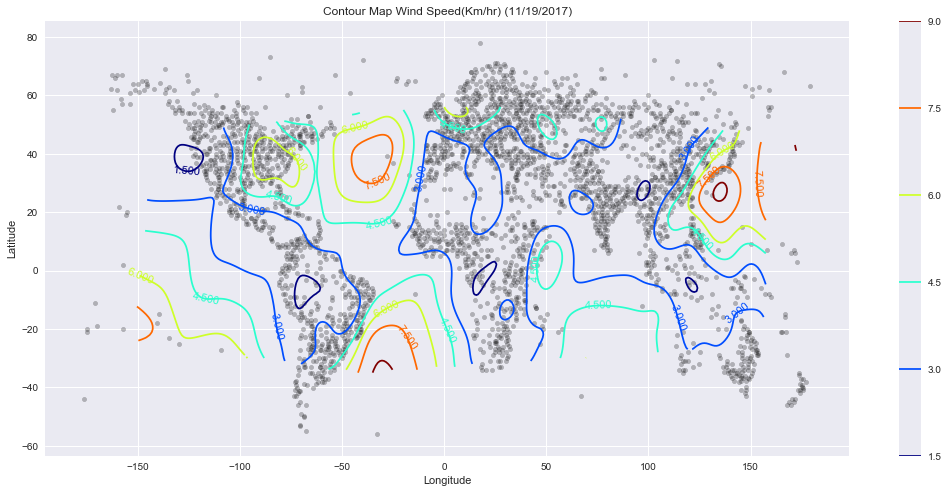

In [418]:
Z=df.wind_speed.values
#Interpolate zi based on X,Y,Z values land them in the xi,yi grid
zi = griddata((X, Y) ,Z ,(xi, yi), method='linear')

#Plot new contour with overlay of original scatter plot


zi2 = ndimage.gaussian_filter(zi, sigma=5, order=0)
fig, ax = plt.subplots(1,1, figsize=(18,8))
contours=plt.contour(xi, yi, zi2, alpha=1, cmap=plt.cm.jet)
plt.clabel(contours, inline=False, fontsize=11)
plt.colorbar()
ax = plt.gca()
df.plot('lng', 'lat', kind='scatter', ax=ax, color='black', alpha=0.25)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title(f'Contour Map Wind Speed(Km/hr) {dat}')
plt.savefig('contour_WindSpeed')
plt.show();

## Contour Map Humidity(%) 

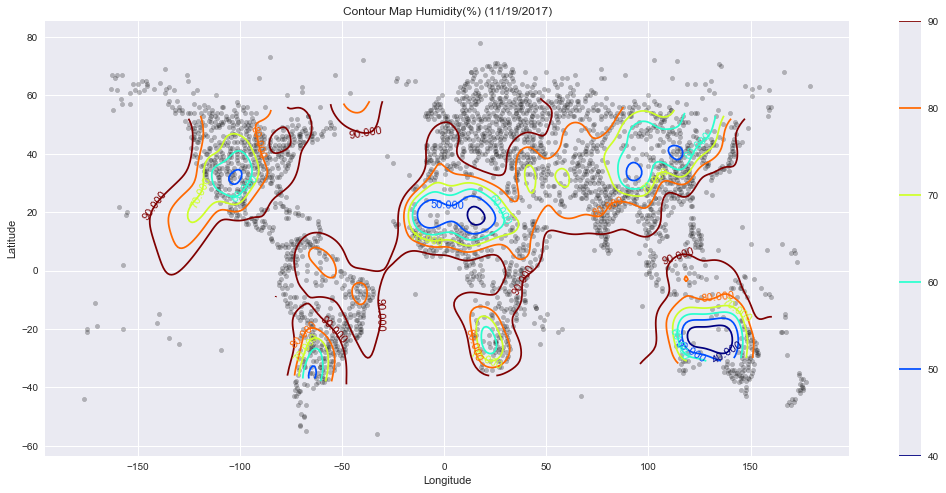

In [414]:
Z=df.humidity.values
#Interpolate zi based on X,Y,Z values land them in the xi,yi grid
zi = griddata((X, Y) ,Z ,(xi, yi), method='linear')

#Plot new contour with overlay of original scatter plot


zi2 = ndimage.gaussian_filter(zi, sigma=4, order=0)
fig, ax = plt.subplots(1,1, figsize=(18,8))
contours=plt.contour(xi, yi, zi2, alpha=1, cmap=plt.cm.jet)
plt.clabel(contours, inline=False, fontsize=11)

plt.colorbar()
ax = plt.gca()
df.plot('lng', 'lat', kind='scatter', ax=ax, color='black', alpha=0.25)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title(f'Contour Map Humidity(%) {dat}')
plt.savefig('contour_WindHumidity')
plt.show();